# Data collection

In [247]:
import numpy as np
import pandas as pd
import os

In [250]:
!python --version

Python 3.9.7


In [2]:
# get data
df = pd.read_csv('data/public_train.csv')
df.head()

,id,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post,label
0,1,389c669730cb6c54314a46be785cea42,"THĂNG CẤP BẬC HÀM ĐỐI VỚI 2 CÁN BỘ, CHIẾN SỸ H...",1585945439,19477,378,173.0,0
1,2,775baa6d037b6d359b229a656eaeaf08,<URL>,1588939166.0,11,5,3,0
2,3,b9f3394d2aff86d85974f5040c401f08,TƯ VẤN MÙA THI: Cách nộp hồ sơ để trúng tuyển ...,1591405213,48,5,19.0,0
3,4,808e278b22ec6b96f2faf7447d10cd8e,Cơ quan Cạnh tranh và Thị trường Anh quyết địn...,1592023613,3,0,0.0,0
4,5,f81bdd6d8be4c5f64bb664214e47aced,Thêm 7 ca tại Quảng Nam liên quan đến hành khá...,1583737358,775,0,54.0,0


In [3]:
label_count = df.value_counts('label')
label_count

label
0    3638
1     734
dtype: int64

In [4]:
# check null value in data
df.isnull().sum()

id                    0
user_name             0
post_message          1
timestamp_post       96
num_like_post       115
num_comment_post     10
num_share_post      725
label                 0
dtype: int64

In [5]:
# check duplicate data
df[df.duplicated('post_message')]

,id,user_name,post_message,timestamp_post,num_like_post,num_comment_post,num_share_post,label
150,151,dd35242704071b7ddf90a8ee90055ec4,<URL>,1588947622.0,87,4,1,0
175,176,79c2d500763b7f14f2631a8ab6a71ea4,<URL>,1588917759.0,NaN,0,NaN,0
178,179,59fb67d9b2bd2b380529562035b3bab4,<URL>,1587632107.0,3,2,NaN,0
197,198,ae7c1d8434b0629a83958eac387e7424,Cơ hội có 1-0-2 để cùng nhau xây dựng những cô...,1584262049,2898,50,142.0,0
454,455,654d291ef3011072e7980e89293fbdac,<URL>,1592663724.0,4,0,NaN,0
...,...,...,...,...,...,...,...,...
4069,4070,849a708a4631a8152557798796b3e09c,<URL>,1591778650.0,3,0,1,0
4108,4109,40bca5be47ef18a26ce6ec19650e6b69,<URL>,1591921753.0,8,0,NaN,0
4247,4248,abd4d580d75bbfce0d52e0b963e035aa,[<URL>](<URL>),1587138493.0,58,9,2,0
4274,4275,bb1247add19beb5eb972410460a0469c,<URL>,1592462355.0,19,3,2,0


In [6]:
# convert unknown record to 0 value
df.iloc[:, 4:7] = df.iloc[:, 4:7].replace('unknown', 0)

# cast from Dtype object to int64 
for i in range(3, 7):
  df.iloc[:, i] = pd.to_numeric(df.iloc[:, i], errors='coerce', downcast='integer')
  
# convert timestamp to date format
df['timestamp_post'] = pd.to_datetime(df['timestamp_post'], unit='s', errors='coerce')

In [7]:
# remove null, duplicate text content record
df = df.dropna(subset=['post_message'])
df['timestamp_post'] = df['timestamp_post'].fillna(pd.Timestamp(0)) # empty timestamp
df = df.fillna(0)
df = df.drop_duplicates(subset='post_message', keep='first')

# convert dtype of num_like, comment, share feature to int64
df.iloc[:, 4:7] = df.iloc[:, 4:7].astype('int64')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4288 entries, 0 to 4371
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                4288 non-null   int64         
 1   user_name         4288 non-null   object        
 2   post_message      4288 non-null   object        
 3   timestamp_post    4288 non-null   datetime64[ns]
 4   num_like_post     4288 non-null   int64         
 5   num_comment_post  4288 non-null   int64         
 6   num_share_post    4288 non-null   int64         
 7   label             4288 non-null   int64         
dtypes: datetime64[ns](1), int64(5), object(2)
memory usage: 301.5+ KB


In [9]:
# get stopwords list
f = open('data/vietnamese-stopwords.txt', 'r', encoding="utf8")
stopwords = f.read().split('\n')

# TF-IDF features

In [88]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pyvi import ViTokenizer
from underthesea import word_tokenize, pos_tag
import time
import string

In [65]:
# remove stopwords in news text
def clean_stopwords(text_list):
  ''' sent_list: already tokenized text in list type
  '''
  clean_text = []
  for word in text_list:
    if word not in stopwords:
      clean_text.append(word.lower())
  return clean_text

def tokenize(text):
  text = text.translate(str.maketrans('', '', string.punctuation)) # clean punctuation
  text = word_tokenize(text.lower()) #tokenize, word segment
  print(text)
  return clean_stopwords(text)

In [66]:
tokenize(df['post_message'][2])

['tư vấn', 'mùa', 'thi', 'cách', 'nộp', 'hồ sơ', 'để', 'trúng tuyển', 'cao', 'nhất', 'vào', 'lúc', '15', 'giờ', 'ngày', '66', 'chương trình', 'tư vấn', 'mùa', 'thi', 'do', 'báo', 'thanh niên', 'thực hiện', 'đã', 'được', 'truyền hình', 'trên', 'đài phát thanh truyền hình', 'bình dương', 'đồng thời', 'trực tuyến', 'trên', 'url', 'fanpage', 'facebook', 'và', 'kênh', 'youtube', 'của', 'báo', 'thanh niên', 'tưvấnmùathi', 'thithptquốcgia', 'thithpt2020']


['tư vấn',
 'mùa',
 'thi',
 'nộp',
 'hồ sơ',
 'trúng tuyển',
 '15',
 '66',
 'chương trình',
 'tư vấn',
 'mùa',
 'thi',
 'báo',
 'thanh niên',
 'truyền hình',
 'đài phát thanh truyền hình',
 'bình dương',
 'trực tuyến',
 'url',
 'fanpage',
 'facebook',
 'kênh',
 'youtube',
 'báo',
 'thanh niên',
 'tưvấnmùathi',
 'thithptquốcgia',
 'thithpt2020']

In [12]:
start = time.time()

# get tfidf vectors with n_gram = 2
vectorizer = TfidfVectorizer(tokenizer=tokenize, ngram_range=(1, 2), max_features=50000)
X_tfidf = vectorizer.fit_transform(df['post_message'])

end = time.time()
print(end - start)

67.08804726600647


In [13]:
start = time.time()

# reduce dimensionality of tfidf vector to 100 dimensions as recommended for tfidf
svd = TruncatedSVD(n_components=100, algorithm='arpack')
X_tfidf_svd = svd.fit_transform(X_tfidf)

end = time.time()
print(end - start)

1.1766338348388672


In [14]:
# scale data to (0, 1) range as we've performed dimension reduction
scaler1 = MinMaxScaler()
X1 = scaler1.fit_transform(X_tfidf_svd)

# Custom features

In [200]:
def extract_feature(data):
  
  text = data[2] # get text content
  
  num_punct, num_one, num_two, num_three_gtt, \
  num_numbers, num_stopwords, \
  num_upper, num_any_upper, num_hashtag, \
  num_N , num_V, num_A, num_url = [0]*13
  
  tokens = word_tokenize(text)
  distinct = set()
  
  for token in tokens:
    
    if token in string.punctuation:
      num_punct+=1
    
    if len(token.split()) == 1:
      num_one+=1
    elif len(token.split()) == 2:
      num_two+=1
    else:
      num_three_gtt+=1
      
    if token.isnumeric(): 
      num_numbers+=1
      
    if token.lower() in stopwords:
      num_stopwords+=1
      
    if token.isupper():
      num_upper+=1
      
    if any(char.isupper() for char in token):
      num_any_upper+=1
      
    if token.startswith('#'):
      num_hashtag+=1
      
    if 'url' in token.lower():
      num_url+=1
      
    '''if tag == 'N':
      num_N.append(token)
      
    if tag == 'A':
      num_A.append(token)
      
    if tag == 'V':
      num_V.append(token)'''
      
    distinct.add(token.lower())
  
  features = [len(tokens), # number of total word tokens (without punctuation)
              #len(text), # number of characters 
              num_punct, # number of punctuation
              num_one, # number of 1 word tokens
              num_two, # number of 2 words tokens
              num_three_gtt, # number of >=3 words tokens
              num_numbers, # number of token that is numeric
              num_stopwords, # number of token that is a stopword
              num_upper, # number of token that is in full CAPITAL
              num_any_upper, # number of token that contains any CAPITAL character
              len(distinct), # number of distinct tokens
              num_hashtag, # number of hashtags
              data[4], # number of likes on post
              data[5], # number of comments on post
              data[6], # number of shares
              data[3].hour,
              data[3].day_of_week,
              data[3].month,
              data[3].day,
              num_url,
              #num_N , num_V, num_A,
             ]
  return features

In [201]:
start = time.time()

# extract custom features 
X_cf = np.array([extract_feature(df.iloc[i, :]) for i in range(df.shape[0])])

end = time.time()
print(end - start)

82.19116616249084


In [202]:
# example of custom features extraction
print(df['post_message'][2])

pd.DataFrame(X_cf[2], index=['Total tokens', 'Punctuation',
                             '1 word', '2 words', '>=3 words', 'Numeric', 
                             'Stopwords', 'CAPITAL', '1 CAPITAL', 'Distinct',
                             'Hashtags', 'Likes', 'Comments', 'Shares',
                             'Hour', 'Weekday', 'Month', 'Day', 'URL'])

TƯ VẤN MÙA THI: Cách nộp hồ sơ để trúng tuyển cao nhất

Vào lúc 15 giờ ngày 6.6, chương trình Tư vấn mùa thi do Báo Thanh Niên thực hiện đã được truyền hình trên Đài Phát thanh- Truyền hình Bình Dương, đồng thời trực tuyến trên <URL>, Fanpage Facebook và kênh YouTube của Báo Thanh Niên.

    #TưVấnMùaThi #ThiTHPTQuốcgia #ThiTHPT2020


,0
Total tokens,54
Punctuation,11
1 word,37
2 words,16
>=3 words,1
Numeric,1
Stopwords,16
CAPITAL,3
1 CAPITAL,18
Distinct,45


In [203]:
scaler2 = MinMaxScaler()
X2 = scaler2.fit_transform(X_cf)

# Combine 2 features

In [204]:
# combine tf-idf and custom features
X_cb = []
for i in range(len(X_cf)):
  X_cb.append(np.append(X_tfidf_svd[i], X_cf[i]))
X_cb = np.array(X_cb)
X_cb.shape

(4288, 119)

In [205]:
scaler3 = MinMaxScaler()
X3 = scaler3.fit_transform(X_cb)

# Data preparation

In [206]:
from sklearn.model_selection import train_test_split

In [228]:
y = np.array(df['label'])

In [229]:
X1_train, X1_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=42)
X2_train, X2_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=42)
X3_train, X3_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=42)

print('Tập train:', len(X1_train))
print('\t Tin thật:', len([i for i in y_train if i == 0]))
print('\t Tin giả:', len([i for i in y_train if i == 1]))
print()
print('Tập test:', len(X1_test))
print('\t Tin thật:', len([i for i in y_test if i == 0]))
print('\t Tin giả:', len([i for i in y_test if i == 1]))

Tập train: 3430
	 Tin thật: 2867
	 Tin giả: 563

Tập test: 858
	 Tin thật: 700
	 Tin giả: 158


# Models

In [230]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import svm
from xgboost import XGBClassifier
import lightgbm as lgb

In [231]:
def knn(X_train, X_test, y_train):
  neigh = KNeighborsClassifier(n_neighbors=3)
  neigh.fit(X_train, y_train)
  y_pred_neigh = neigh.predict(X_test)
  return y_pred_neigh

def decision_tree(X_train, X_test, y_train):
  tree = DecisionTreeClassifier(random_state=0)
  tree.fit(X_train, y_train)
  y_pred_tree = tree.predict(X_test)
  return y_pred_tree

def svc(X_train, X_test, y_train):
  clf_svc = svm.LinearSVC()#kernel='linear')
  clf_svc.fit(X_train, y_train)
  y_pred_svc = clf_svc.predict(X_test)
  return y_pred_svc

def random_forest(X_train, X_test, y_train):
  clf_rf = RandomForestClassifier(random_state=0)
  clf_rf.fit(X_train, y_train)
  y_pred_rf = clf_rf.predict(X_test)
  return y_pred_rf

def lgbm(X_train, X_test, y_train):
  clf_lgbm = lgb.LGBMClassifier(random_state=0)
  clf_lgbm.fit(X_train, y_train)
  y_pred_lgbm = clf_lgbm.predict(X_test)
  return y_pred_lgbm

def xgb(X_train, X_test, y_train):
  clf_xgb = XGBClassifier(eval_metric='logloss', use_label_encoder=False)
  clf_xgb.fit(X_train, y_train)
  y_pred_xgb = clf_xgb.predict(X_test)
  return y_pred_xgb

def sgd(X_train, X_test, y_train):
  clf_sgd = SGDClassifier(random_state=0)
  clf_sgd.fit(X_train, y_train)
  y_pred_sgd = clf_sgd.predict(X_test)
  return y_pred_sgd

In [232]:
'''from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(17000, input_dim=X1.shape[1], activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
print(model.summary())

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X1_train, y_train, epochs=10)'''

'''pred1_mlp = model.predict(X1_test)
print(model.evaluate(X1_test, y_test))
roc_auc_score(y_test, pred1_mlp)'''

'pred1_mlp = model.predict(X1_test)\nprint(model.evaluate(X1_test, y_test))\nroc_auc_score(y_test, pred1_mlp)'

In [233]:
# tfidf
pred1_tree = decision_tree(X1_train, X1_test, y_train)
pred1_lr = logistic_regression(X1_train, X1_test, y_train)
pred1_knn = knn(X1_train, X1_test, y_train)
pred1_svc = svc(X1_train, X1_test, y_train)
pred1_rf = random_forest(X1_train, X1_test, y_train)
pred1_lgbm = lgbm(X1_train, X1_test, y_train)
pred1_xgb = xgb(X1_train, X1_test, y_train)
pred1_sgd = sgd(X1_train, X1_test, y_train)

In [234]:
# custom features
pred2_tree = decision_tree(X2_train, X2_test, y_train)
pred2_lr = logistic_regression(X2_train, X2_test, y_train)
pred2_knn = knn(X2_train, X2_test, y_train)
pred2_svc = svc(X2_train, X2_test, y_train)
pred2_rf = random_forest(X2_train, X2_test, y_train)
pred2_lgbm = lgbm(X2_train, X2_test, y_train)
pred2_xgb = xgb(X2_train, X2_test, y_train)
pred2_sgd = sgd(X2_train, X2_test, y_train)

In [235]:
# combined features
pred3_tree = decision_tree(X3_train, X3_test, y_train)
pred3_lr = logistic_regression(X3_train, X3_test, y_train)
pred3_knn = knn(X3_train, X3_test, y_train)
pred3_svc = svc(X3_train, X3_test, y_train)
pred3_rf = random_forest(X3_train, X3_test, y_train)
pred3_lgbm = lgbm(X3_train, X3_test, y_train)
pred3_xgb = xgb(X3_train, X3_test, y_train)
pred3_sgd = sgd(X3_train, X3_test, y_train)

# Evaluation

In [236]:
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
import seaborn as sns
import matplotlib.pyplot as plt
from textwrap import wrap

In [237]:
def evaluate(pred, true):
  #print('-----------------------------------------------------')
  acc = accuracy_score(pred, true)
  print(classification_report(pred, true))
  print('Accuracy:', acc)
  auc = roc_auc_score(pred, true)
  print('AUC:', auc)
  print('-----------------------------------------------------')
  print()
  return acc, auc

In [238]:
# evaluation on tfidf features

print('Logistic Regression')
acc1_lr, auc1_lr = evaluate(pred1_lr, y_test)

print('K-nearest-neighbor')
acc1_knn, auc1_knn = evaluate(pred1_knn, y_test)

print('SVM')
acc1_svc, auc1_svc = evaluate(pred1_svc, y_test)

print('Decision Tree')
acc1_tree, auc1_tree = evaluate(pred1_tree, y_test)

print('Random Forest')
acc1_rf, auc1_rf = evaluate(pred1_rf, y_test)

print('LightGBM')
acc1_lgbm, auc1_lgbm = evaluate(pred1_lgbm, y_test)

print('XGB')
acc1_xgb, auc1_xgb = evaluate(pred1_xgb, y_test)

print('SGD')
acc1_sgd, auc1_sgd = evaluate(pred1_sgd, y_test)

Logistic Regression
              precision    recall  f1-score   support

           0       0.99      0.86      0.92       806
           1       0.27      0.81      0.40        52

    accuracy                           0.85       858
   macro avg       0.63      0.83      0.66       858
weighted avg       0.94      0.85      0.89       858

Accuracy: 0.8531468531468531
AUC: 0.8318858560794045
-----------------------------------------------------

K-nearest-neighbor
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       774
           1       0.30      0.57      0.40        84

    accuracy                           0.83       858
   macro avg       0.63      0.71      0.65       858
weighted avg       0.89      0.83      0.85       858

Accuracy: 0.8298368298368298
AUC: 0.7146548541897378
-----------------------------------------------------

SVM
              precision    recall  f1-score   support

           0       0.98      0.8

In [239]:
# evaluation on custom features

print('Logistic Regression')
acc2_lr, auc2_lr = evaluate(pred2_lr, y_test)

print('K-nearest-neighbor')
acc2_knn, auc2_knn = evaluate(pred2_knn, y_test)

print('SVM')
acc2_svc, auc2_svc = evaluate(pred2_svc, y_test)

print('Decision Tree')
acc2_tree, auc2_tree = evaluate(pred2_tree, y_test)

print('Random Forest')
acc2_rf, auc2_rf = evaluate(pred2_rf, y_test)

print('LightGBM')
acc2_lgbm, auc2_lgbm = evaluate(pred2_lgbm, y_test)

print('XGB')
acc2_xgb, auc2_xgb = evaluate(pred2_xgb, y_test)

print('SGD')
acc2_sgd, auc2_sgd = evaluate(pred2_sgd, y_test)

Logistic Regression
              precision    recall  f1-score   support

           0       1.00      0.82      0.90       857
           1       0.00      0.00      0.00         1

    accuracy                           0.81       858
   macro avg       0.50      0.41      0.45       858
weighted avg       1.00      0.81      0.90       858

Accuracy: 0.8146853146853147
AUC: 0.40781796966161027
-----------------------------------------------------

K-nearest-neighbor
              precision    recall  f1-score   support

           0       0.92      0.84      0.88       770
           1       0.20      0.36      0.26        88

    accuracy                           0.79       858
   macro avg       0.56      0.60      0.57       858
weighted avg       0.85      0.79      0.81       858

Accuracy: 0.7878787878787878
AUC: 0.6000000000000001
-----------------------------------------------------

SVM
              precision    recall  f1-score   support

           0       1.00      0.

In [240]:
# evaluation on combined features

print('Logistic Regression')
acc3_lr, auc3_lr = evaluate(pred3_lr, y_test)

print('K-nearest-neighbor')
acc3_knn, auc3_knn = evaluate(pred3_knn, y_test)

print('SVM')
acc3_svc, auc3_svc = evaluate(pred3_svc, y_test)

print('Decision Tree')
acc3_tree, auc3_tree = evaluate(pred3_tree, y_test)

print('Random Forest')
acc3_rf, auc3_rf = evaluate(pred3_rf, y_test)

print('LightGBM')
acc3_lgbm, auc3_lgbm = evaluate(pred3_lgbm, y_test)

print('XGB')
acc3_xgb, auc3_xgb = evaluate(pred3_xgb, y_test)

print('SGD')
acc3_sgd, auc3_sgd = evaluate(pred3_sgd, y_test)

Logistic Regression
              precision    recall  f1-score   support

           0       0.98      0.86      0.92       801
           1       0.28      0.77      0.41        57

    accuracy                           0.85       858
   macro avg       0.63      0.81      0.66       858
weighted avg       0.93      0.85      0.88       858

Accuracy: 0.8519813519813519
AUC: 0.8148038635915632
-----------------------------------------------------

K-nearest-neighbor
              precision    recall  f1-score   support

           0       0.96      0.86      0.91       775
           1       0.33      0.63      0.43        83

    accuracy                           0.84       858
   macro avg       0.64      0.74      0.67       858
weighted avg       0.90      0.84      0.86       858

Accuracy: 0.8403263403263403
AUC: 0.7448659152739994
-----------------------------------------------------

SVM
              precision    recall  f1-score   support

           0       0.97      0.8

In [241]:
print('Accuracy')
models = ['Logistic Regression', 'KNN', 'SVM', 'Decision Tree', 'Random Forest', 'LightGBM', 'XGB', 'SGD']
acc1 = np.around([acc1_lr, acc1_knn, acc1_svc, acc1_tree, acc1_rf, acc1_lgbm, acc1_xgb, acc1_sgd], 2)
acc2 = np.around([acc2_lr, acc2_knn, acc2_svc, acc2_tree, acc2_rf, acc2_lgbm, acc2_xgb, acc2_sgd], 2)
acc3 = np.around([acc3_lr, acc3_knn, acc3_svc, acc3_tree, acc3_rf, acc3_lgbm, acc3_xgb, acc3_sgd], 2)

acc_df = pd.DataFrame([acc1, acc2, acc3], columns=models, index=['TF-IDF', 'Custom', 'Combined'])
acc_df.T

Accuracy


,TF-IDF,Custom,Combined
Logistic Regression,0.85,0.81,0.85
KNN,0.83,0.79,0.84
SVM,0.86,0.81,0.86
Decision Tree,0.79,0.80,0.82
Random Forest,0.84,0.85,0.85
LightGBM,0.87,0.87,0.89
XGB,0.86,0.86,0.88
SGD,0.86,0.81,0.85


In [242]:
auc1 = np.around([auc1_lr, auc1_knn, auc1_svc, auc1_tree, auc1_rf, auc1_lgbm, auc1_xgb, auc1_sgd], 2)
auc2 = np.around([auc2_lr, auc2_knn, auc2_svc, auc2_tree, auc2_rf, auc2_lgbm, auc2_xgb, auc2_sgd], 2)
auc3 = np.around([auc3_lr, auc3_knn, auc3_svc, auc3_tree, auc3_rf, auc3_lgbm, auc3_xgb, auc3_sgd], 2)

auc_df = pd.DataFrame([auc1, auc2, auc3], columns=models, index=['TF-IDF', 'Custom', 'Combined'])
auc_df.T

,TF-IDF,Custom,Combined
Logistic Regression,0.83,0.41,0.81
KNN,0.71,0.60,0.74
SVM,0.81,0.61,0.80
Decision Tree,0.66,0.68,0.70
Random Forest,0.86,0.81,0.88
LightGBM,0.83,0.80,0.87
XGB,0.82,0.78,0.86
SGD,0.82,0.41,0.82


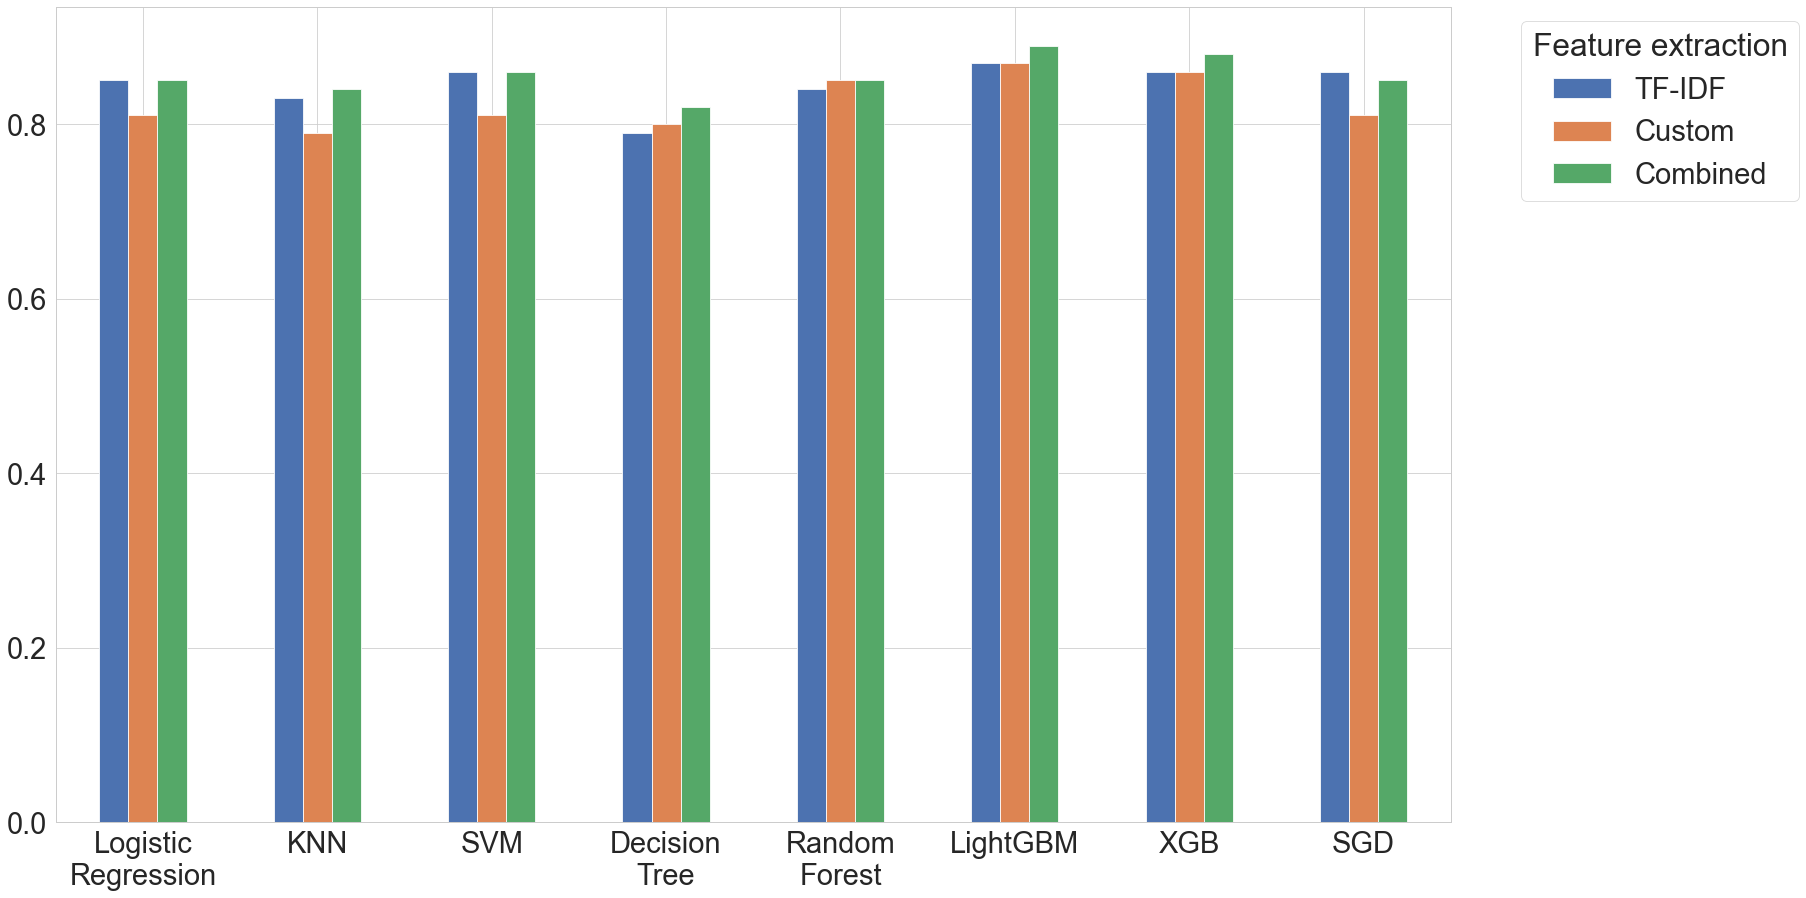

In [243]:
# accuracy plot
labels = ['\n'.join(wrap(x, 12)) for x in  models] # custom label multi-line
sns.axes_style("whitegrid")
sns.set_context('paper', font_scale=3.3)
acc_df.T.plot(kind='bar', figsize=(25, 15), rot=0)
plt.xticks(range(len(labels)), labels)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='Feature extraction')

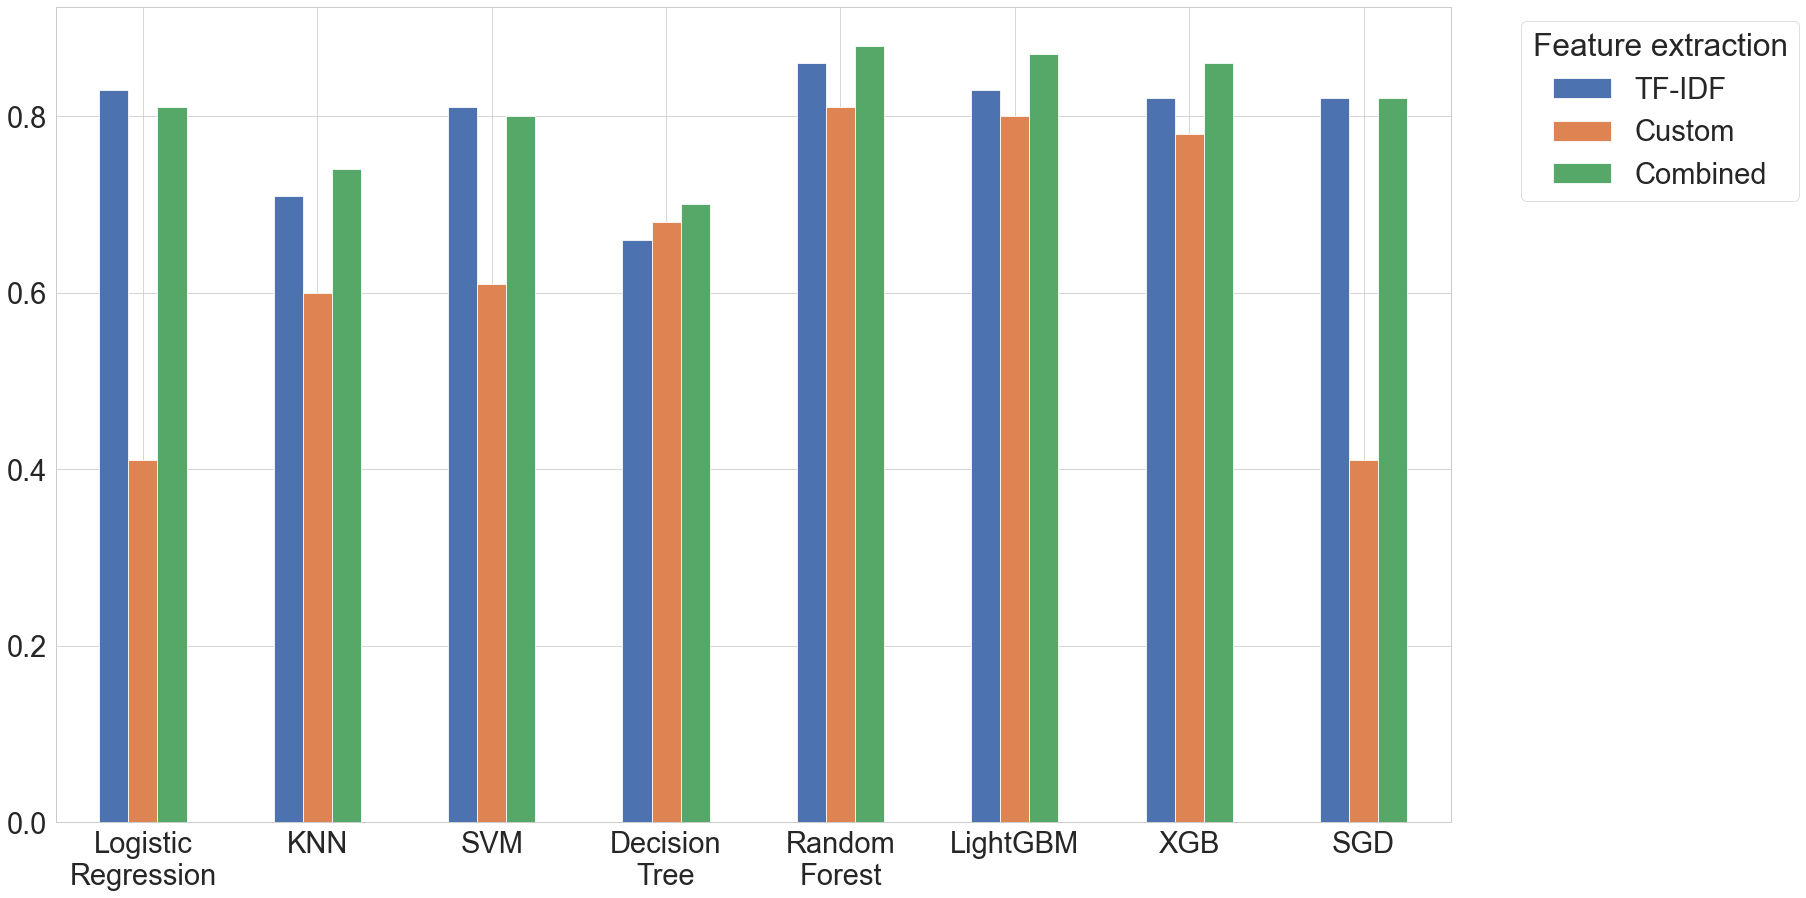

In [245]:
# auc plot
sns.set_context('paper', font_scale=3.3)
auc_df.T.plot(kind='bar', figsize=(25, 15), rot=0)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left")
plt.xticks(range(len(labels)), labels)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='Feature extraction')